In [69]:
import pickle
from functools import partial
from math import pi
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from scipy.optimize import newton_krylov

from tqdm import tqdm_notebook as tqdm

from pybem.core import Airfoil, Propeller

In [9]:
################################################################################
path_polar = Path(r'D:\Users\emillan\misCodigos\Notebooks\pybem\pybem\data\naca0012.csv')

airfoil_data_df = pd.read_csv(path_polar.open(mode='r')) 
airfoil_data_df = airfoil_data_df.astype(float)

alpha    = airfoil_data_df['Alpha'].values
polar_cl = airfoil_data_df['Cl'].values
polar_cd = airfoil_data_df['Cd'].values

airfoil = Airfoil(alpha, polar_cl, polar_cd)
                  

In [26]:
################################################################################

# Create propeller parameters
J   = 1.0
D   = 1.0
N_b = 4

def solidity(r):
    NUM = 2.0 * pi * r * D 
    DEN = N_b * propeller.chord(r)
    return NUM / DEN

def tan_phi(r):
    return J / r / 2.0 / pi

# Create distributions
N = 50
# r_hat = r / D
r_hat = np.linspace(0.1, 0.5, N)
chord = np.linspace(1.0, 0.25, N)

tan0 = np.rad2deg(np.arctan(tan_phi(r_hat[0])))
tanN = np.rad2deg(np.arctan(tan_phi(r_hat[-1])))
twist = np.linspace(60.0, 0, N)

propeller = Propeller(r_hub      = 0.0, 
                      r_tip      = 0.0,
                      r_dist     = r_hat,
                      beta_dist  = twist,
                      chord_dist = chord)

In [36]:
################################################################################
def residual(theta, r):

    _S = solidity(r)
    
    # Compute base effective pitch
    _tan_phi = tan_phi(r) 
    phi0 = np.rad2deg(np.arctan(_tan_phi))

    # Compute airfoil angle
    _twist = propeller.beta(r)
    _alpha = _twist - (phi0 + theta)
    
    return phi0, _alpha, _twist

    try:
        _cl = airfoil.cl(_alpha)
        _cd = airfoil.cd(_cl)
    except:
        print('phi0:', phi0)
        print('twist:', _twist)
        print('alpha:', _alpha)
        print('theta:', theta)
        raise ValueError

    _tan_gamma = _cd / _cl

    # Get angles in the right degrees
    _theta = np.deg2rad(theta)
    _phi   = np.deg2rad(phi0 + theta)

    NUM = 1.0 - _tan_gamma   * np.tan(_theta)
    DEN = 4.0 * np.sin(_phi) * np.tan(_theta)

    return _S / _cl - NUM / DEN 

In [74]:
probes = []

for _j in tqdm(np.linspace(0.2, 1.5, 10)): 
    J = _j
    for _theta in tqdm(np.linspace(-10.0,20), leave = False):
    
        phi0, _alpha, _twist = residual(_theta, r_hat[0])
        
        probes.append({'J': _j, 'theta':_theta, 'phi0': phi0, 'alpha':_alpha})

In [75]:
probes_df = pd.DataFrame(probes)

In [76]:
j_groups = probes_df.groupby(by='J').groups

Text(0, 0.5, 'alpha')

Text(0, 0.5, 'phi0')

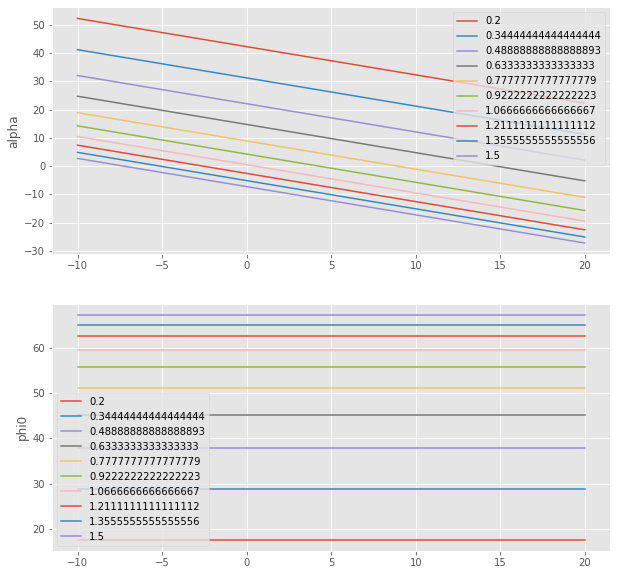

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize =(10,10))

for j, indices in j_groups.items():
    
    _df = probes_df.loc[indices].copy()
    _df = _df.set_index('theta')
    
    ax1.plot(_df.index, _df['alpha'], label = str(j));
    ax2.plot(_df.index, _df['phi0'], label = str(j));
    
ax1.set_ylabel('alpha')
ax2.set_ylabel('phi0')
ax1.legend()
ax2.legend()

In [30]:
inference_angles = []

for radius in r_hat:
    _residual = partial(residual, r = radius)
    inference_angles.append({'r': radius, 'theta': newton_krylov(_residual, ).item()})

theta_df = pd.DataFrame(inference_angles).set_index('r') 

NoConvergence: 1.9791967810772235

In [ ]:
def angles_distribution(theta, r):

    _S = solidity(r)
    
    # Compute base effective pitch
    _tan_phi = tan_phi(r) 
    phi0 = np.rad2deg(np.arctan(_tan_phi))

    # Compute airfoil angle
    _twist = propeller.beta(r)
    _alpha = _twist - (phi0)

    _cl = airfoil.cl(_alpha)
    _cd = airfoil.cd(_cl)

    _tan_gamma = _cd / _cl

    # Get angles in the right degrees
    _theta = np.deg2rad(theta)
    _phi   = np.deg2rad(phi0 + theta)

    return {'twist': _twist, 'alpha':_alpha, 'phi': _phi, 'r': r, 'theta': theta}

#%%
distributions = []

for radius in theta_df.index:
    distributions.append(angles_distribution(theta_df.loc[radius].values[0], radius))

distributions_df = pd.DataFrame(distributions)
distributions_df = distributions_df.set_index('r')
#%%